In [ ]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
pip install openai tiktoken

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""  # paste your key here


In [ ]:
from openai import OpenAI
client = OpenAI()

resp = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[{"role": "user", "content": "Say 'API connection successful'"}],
    max_tokens=10
)

print(resp.choices[0].message.content)

API connection successful.


In [ ]:
from openai import OpenAI
client = OpenAI()   # connects to OpenAI’s servers using your API key
MODEL = "gpt-4.1-nano"    # you can also try "gpt-4o" or "gpt-3.5-turbo"
DATA_DIR = Path.cwd().parent / "data"

In [ ]:
df = pd.read_csv(DATA_DIR / "/content/train.csv", index_col=0)

In [ ]:
df

text  \
paper_id                                                      
0         ## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCI...   
1         ## 1. Introduction\n\n\nAn Electronic Health R...   
2         ## Introduction\n\n\nTranslation  plays  an  i...   
3         ## 1 Problem Setup\n\n\nRecent political scien...   
4         ## INTRODUCTION\n\n\nThis  article  investigat...   
...                                                     ...   
995       ## Methods\n\n\n\n## Sample\n\n\nOur data come...   
996       ## Introduction\n\n\nCanada is a high-income c...   
997       ## Introduction\n\n\nCultural studies has ofte...   
998       ## 1. Introduction\n\n\nTwentieth century plan...   
999       ## 1. Introduction\n\n\nLongleaf pine ( Pinus ...   

                                                    summary  
paper_id                                                     
0         In this article, Victor Fan argues that analys...  
1         Problem definition: Physicians spend more than...  
2         Literary translation is one of the most challe...  
3         There is a long-running debate on evaluating f...  
4         Recently, ‘bimajyo’ (美魔女) came into focus in J...  
...                                                     ...  
995       Demand for democratic accountability in polici...  
996       Canada’s employment standards laws and mandato...  
997       Cultural studies has often favoured a Foucauld...  
998       Vehicular air pollution has created an ongoing...  
999       For the last several decades, a substantial am...  

[1000 rows x 2 columns]

In [ ]:
print(f"Document length: {len(df.loc[0, 'text']):,} characters")
print("Document:")
print(fill(df.loc[0, "text"], replace_whitespace=False)[:1000])

Document length: 33,416 characters
Document:
## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCIOUSNESS


Since 1997,
the concept of extraterritoriality has been configured in the
political tension between Hong Kong and Beijing. From the perspective
of the Central Government, it is fundamental for the people of China
to shijian zhuquan instantiate its sovereignty over Hong Kong. But
while most Hong / Kong residents insist on interpreting this concept
in terms of the Euro-American notion of selfdetermination  (zizhu /
making decisions  for  oneself),  the  Beijing  government  believes
that  the Hong Kong legislature must make decisions in conformation to
the larger will of the people, which the Party represents, a concept
taken from the writings of Lenin and Stalin (Gao 2010: 26-30). This
tension is crystalised in the long debate about Article 23 of the Hong
Kong Basic Law, which requires  the  SAR  to  'enact  laws  on  its
own  to  prohibit  any  act  of  treason,  secession,  sedition,
s

In [ ]:
print(fill(df.loc[0, "summary"]))

In this article, Victor Fan argues that analysing contemporary Hong
Kong cinema requires active rewriting of established postcolonial
theories by taking into account the specific mode of colonisation of
Hong Kong: extraterritoriality. This concept has been responsible for
the construction of the cultural plurality, linguistic ambiguity, and
political liminality of Hong Kong and its cinematographic experience,
as well as the incongruence between the community’s political
consciousness after 1997 and the larger national imagination
promulgated by the Beijing government. The term ‘extraterritoriality’
was translated into Chinese after 1895 via Japanese as zhiwai faquan
the right to exercise one’s law outside a nation state’s sovereign
terrain, and colonialism in China between 1844 and 1949 was largely
characterized by a continuous reformulation and systematisation of
this concept. It in fact still informs the way former colonised
regions in China are administered today, and the political 

In [ ]:
df["text_len"] = df.text.str.len()
df["summary_len"] = df.summary.str.len()
df["text_len_log"] = np.log10(df.text_len)
df["summary_len_log"] = np.log10(df.summary_len)

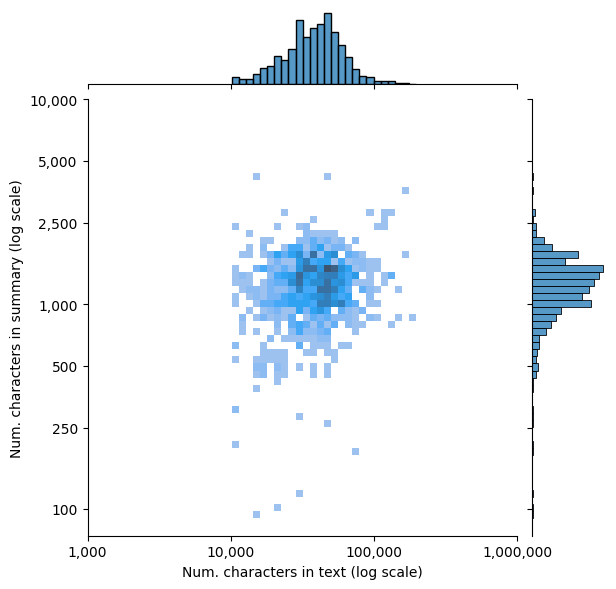

In [ ]:
g = sns.jointplot(df, x="text_len_log", y="summary_len_log", kind="hist")
xticks = [3, 4, 5, 6]
yticks = [2, np.log10(250), np.log10(500), 3, np.log10(2_500), np.log10(5_000), 4]
g.ax_marg_x.set_xticks(xticks, [f"{10**tick:,.0f}" for tick in xticks])
g.ax_marg_y.set_yticks(yticks, [f"{10**tick:,.0f}" for tick in yticks])
g.set_axis_labels(
    "Num. characters in text (log scale)", "Num. characters in summary (log scale)"
)

In [ ]:
df.describe()

text_len  summary_len  text_len_log  summary_len_log
count    1000.000000  1000.000000   1000.000000      1000.000000
mean    42050.269000  1275.241000      4.574534         3.079240
std     21412.146068   426.262199      0.207977         0.162033
min     10145.000000    90.000000      4.006252         1.954243
25%     28381.500000  1008.500000      4.453035         3.003676
50%     38962.000000  1258.500000      4.590641         3.099853
75%     51263.250000  1501.250000      4.709806         3.176453
max    196911.000000  4359.000000      5.294270         3.639387

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=0)
f"Train shape: {train.shape}; Test shape: {test.shape}"

'Train shape: (700, 6); Test shape: (300, 6)'

In [ ]:
train, validation = train_test_split(train, test_size=0.30, random_state=0)
f"Train shape: {train.shape}; Validation shape: {validation.shape}; Test shape: {test.shape}"

'Train shape: (490, 6); Validation shape: (210, 6); Test shape: (300, 6)'

In [ ]:
def doc_and_summary_from_row(doc_row: pd.Series):
    """Pull out the document and summary"""
    return doc_row["text"], doc_row["summary"]


def show_doc_and_summary(doc: str, summary: str, max_len_to_print: int = 500) -> str:
    """Show a little bit of a doc and its summary"""

    return (
        f"Document ({max_len_to_print:,} of {len(doc):,} characters):\n"
        f"{fill(doc[:max_len_to_print], replace_whitespace=False)}...\n\n"
        f"Summary ({len(summary):,} characters):\n"
        f"{fill(summary)}"
    )


doc_row = train.loc[533]
doc, summary = doc_and_summary_from_row(doc_row)

print(show_doc_and_summary(doc, summary))

Document (500 of 135,755 characters):
## 1.1 Policy context


Some 25 per cent of Australians live outside
one of the nation's capitals, resulting in a substantial
nonmetropolitan population in absolute terms, but a much smaller
population relative to the total number resident in the largest
metropolitan centres. Policy for rural and regional housing across
Australia is made complex by federation: the Australian Government has
relatively few direct powers with respect to housing, but remains an
important source of financial support...

Summary (1,405 characters):
This AHURI research examined housing trends and the processes of
delivering affordable housing supply in rural and regional Australia.
These rural and regional housing markets have faced substantial
challenges for more than three decades, including poor housing
affordability; under-developed supply chains; the shortage of skilled
and unskilled labour force; increasing demand for housing in some
localities, while other centres 

In [ ]:
prompt_template = 'Here is a terrific one-sentence summary of "{doc}": '
prompt = prompt_template.format(doc=doc) #limit to 4000 characters since api cant take on the whole document
#prompt = prompt_template.format(doc=doc[:110000]) #limit to 4000 characters since api cant take on the whole document


def show_prompt(prompt: str, start_chars: int = 60, end_chars: int = 30) -> str:
    """Nicely format a prompt"""
    return f"Our prompt ({len(prompt):,} characters):\n{prompt[:start_chars]} ... {prompt[-end_chars:]}"


print(show_prompt(prompt))

Our prompt (135,802 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... e off housing nationwide.

": 


In [ ]:
LLM_SERVER = "https://api.openai.com"
MODEL = "gpt-4.1-nano"

def get_llm_completion(
    prompt: str, max_tokens: int | None = None, top_k: int | None = None
) -> str:
    headers = {
        "Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}",
        "Content-Type": "application/json"
    }
    data = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": max_tokens or 200,
    }
    resp = requests.post(f"{LLM_SERVER}/v1/chat/completions", headers=headers, json=data)
    try:
        return resp.json()["choices"][0]["message"]["content"].strip()
    except KeyError:
        print("API response was not successful. Full response:")
        print(resp.json())
        raise

In [ ]:
completion = get_llm_completion(prompt)
print(prompt_template + "\n\n" + fill(completion, replace_whitespace=False)[:1000])

Here is a terrific one-sentence summary of "{doc}": 

The report comprehensively examines the complex and differentiated
landscape of rural and regional housing in Australia, highlighting the
challenges posed by federation, limited policy support, and
disruptions such as COVID-19 and supply chain issues, while
emphasizing the importance of tailored, place-based policy
interventions, increased government investment, and demand aggregation
strategies to enhance resilience, affordability, and supply in
regional housing markets.


In [ ]:
def count_tokens(text: str) -> int:
    """Count the number of tokens in a string"""
    enc = tiktoken.encoding_for_model("gpt-4o")
    return len(enc.encode(text))

In [ ]:
print(f"Our prompt is {count_tokens(prompt):,} tokens.")

Our prompt is 25,853 tokens.


In [ ]:
print(show_prompt(prompt))

Our prompt (135,802 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... e off housing nationwide.

": 


In [ ]:
shorter_prompt = prompt_template.format(doc=doc[:7_500])
print(f"Our shorter prompt is {count_tokens(shorter_prompt):,} tokens long.")
print(show_prompt(shorter_prompt))

Our shorter prompt is 1,361 tokens long.
Our prompt (7,547 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... rdable rental housing (Mart": 


In [ ]:
completion = get_llm_completion(shorter_prompt)
print(fill(completion, replace_whitespace=False)[:1000])

Australia's complex federal structure presents significant challenges
for rural and regional housing policy, as responsibilities and
resources are dispersed across federal, state, territory, and local
governments, limiting targeted interventions despite various
initiatives like Housing Australia's RFHBG, HAFF, and regional schemes
aimed at increasing affordable and affordable social housing in non-
metropolitan areas.


In [ ]:
prompt_template

'Here is a terrific one-sentence summary of "{doc}": '

In [ ]:
from openai import OpenAI

from openai import OpenAI
client = OpenAI()   # connects to OpenAI’s servers using your API key
MODEL = "gpt-4.1-nano"    # you can also try "gpt-4-turbo" or "gpt-3.5-turbo"

llm_client = OpenAI()

chat_completion = llm_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What's your name, age, and favorite ice cream flavor?",
        }
    ],
    model=MODEL,
    seed=0,
)
print(fill(chat_completion.choices[0].message.content, replace_whitespace=False))

Hello! I don't have a name, age, or personal preferences like favorite
ice cream flavor, but I'm here to help you with anything you'd like to
discuss!


In [ ]:
def ask_llm(prompt: str, max_tokens: int = 500):
    """Get a response from an LLM using the OpenAI client"""
    chat_completion = llm_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=MODEL,
        seed=0,
        max_tokens=max_tokens,
    )
    return chat_completion.choices[0].message.content, chat_completion

In [ ]:
prompt_template = (
    "You are a careful scientific writer.\n"
        "Write a single concise paragraph (3-6 sentences) that summarizes the core claims, methods, and findings.\n"
        "Do not include references, citations, or headings. Only use information from the text:\n\n{doc}"
)
resp, completion = ask_llm(prompt_template.format(doc=doc[:10_000]))

In [ ]:
print(
    f"Prompt tokens     : {completion.usage.prompt_tokens:,}\nCompletion tokens : {completion.usage.completion_tokens:,}"
)

Prompt tokens     : 1,861
Completion tokens : 191


In [ ]:
print(fill(resp, replace_whitespace=False))

This analysis highlights the complex and fragmented nature of rural
and regional housing policy in Australia, shaped by federal, state,
and local governments with limited coordination and resources.
National initiatives such as the Regional First Home Buyer Guarantee,
the Housing Australia Future Fund, and the National Housing Accord aim
to address housing affordability and supply, yet their regional impact
remains constrained by jurisdictional limitations and resource
competition. State-level actions, exemplified by South Australia’s
Regional Key Worker Housing Scheme and New South Wales’ urban
development programs, demonstrate targeted efforts to boost regional
housing supply, while local governments often supplement these by
providing land, supporting affordable rentals, and regulating short-
term rentals, especially in remote areas. Innovative responses are
evident in regional areas like Western Australia’s Pilbara, where
local governments directly develop housing, often at signifi

In [ ]:
def summarize(doc: str, max_doc_chars: int = 7_000) -> str:
    """Summarize (part of) a document"""
    prompt_template = (
        "You are a careful scientific writer.\n"
        "Write a single concise paragraph (3-6 sentences) that summarizes the core claims, methods, and findings.\n"
        "Do not include references, citations, or headings. Only use information from the text:\n\n{doc}"
    )
    resp, completion = ask_llm(prompt_template.format(doc=doc[:max_doc_chars]))
    return resp


def predict_on_dataset(
    df: pd.DataFrame, max_docs: int | None = None, summarize_fn=summarize
) -> dict[int, str]:
    """Generate a summary for every document in a dataframe"""
    doc_id_to_summary = {}
    max_docs = max_docs or df.shape[0]
    for id, row in tqdm(df.head(max_docs).iterrows(), total=max_docs, smoothing=0):
        doc = row["text"]
        doc_id_to_summary[id] = summarize_fn(doc)
    return doc_id_to_summary

In [ ]:
id_to_summary = predict_on_dataset(train, max_docs=5)
id_to_summary

  0%|          | 0/5 [00:00<?, ?it/s]

{827: "Suzuki, a childhood enthusiast of anime and manga, built his career through editorial roles and industry networking, ultimately contributing to the promotion and development of Japanese animation. After joining Tokuma Shoten, he helped produce the influential manga magazine Animage, where he showcased Miyazaki's work and identified emerging talent, notably featuring Miyazaki’s Nausicaä of the Valley of the Wind in 1981, which significantly boosted its popularity. Suzuki’s efforts facilitated Miyazaki and Takahata's collaborations with Tokuma, leading to the production of Nausicaä and the eventual formation of Studio Ghibli. His personal engagement with industry figures and strategic promotion played a crucial role in shaping the careers of major directors and the expansion of anime as a multimedia franchise.",
 166: 'This study examines the quality of the English collaborative translation of Alsanea\'s "Girls of Riyadh," focusing on how linguistic and cultural features are rende

In [ ]:
train_id_to_summary = predict_on_dataset(train)
train_preds = train.assign(my_summary=train_id_to_summary)
train_preds

  0%|          | 0/490 [00:00<?, ?it/s]

text  \
paper_id                                                      
827       ## THE EARLY DAYS\n\n\nSuzuki's link with anim...   
166       ## Introduction\n\n\nThe paper aims to assess ...   
170       ## Introduction\n\n\nThe medical world is cons...   
328       ## 1. Introduction\n\n\nResearch and innovatio...   
347       ## Introduction\n\n\nTeaching writing to ESL s...   
...                                                     ...   
195       ## Introduction\n\n\nSince the 1980s, low-fert...   
948       ## Introduction\n\n\nEmpirically  analyzing  h...   
756       ## 3 Data and Methods\n\n\n213\n\n\n## 3.1 Dat...   
574       2.1 Risk Integration\n\n\nSeveral methods have...   
472       ## BTS MUSIC VIDEOS AND HALLYU\n\n\nK-Pop has ...   

                                                    summary  text_len  \
paper_id                                                                
827       While so-called ‘Ghibli films’ attract global ...     35403   
166       The paper aims to assess the quality of the En...     56832   
170       The medical world is constantly changing. The ...     32191   
328       A current issue in mission-oriented research p...     68076   
347       The present research is a small-scale case stu...     38230   
...                                                     ...       ...   
195       While extensive literature documents the massi...     41787   
948       The causal identification of network effects i...     36116   
756       Interviewer effects are a common challenge in ...     38974   
574       Effective risk management in a multi-business ...     16345   
472       The recent music video ‘Idol’ (published 24 Au...     45772   

          summary_len  text_len_log  summary_len_log  \
paper_id                                               
827              1446      4.549040         3.160168   
166              1964      4.754593         3.293141   
170              2364      4.507734         3.373647   
328              1049      4.832994         3.020775   
347              1518      4.582404         3.181272   
...               ...           ...              ...   
195              1017      4.621041         3.007321   
948               582      4.557700         2.764923   
756              1271      4.590775         3.104146   
574               606      4.213385         2.782473   
472              1284      4.660600         3.108565   

                                                 my_summary  
paper_id                                                     
827       Suzuki's early engagement with manga, film, an...  
166       This study evaluates the quality of the Englis...  
170       This study emphasizes the pervasive stigmatiza...  
328       This study investigates whether current health...  
347       This study examines the challenges faced by ES...  
...                                                     ...  
195       This research investigates how social age norm...  
948       This survey explores the complex landscape of ...  
756       This study analyzes data from the European Soc...  
574       Recent research on risk integration highlights...  
472       This article examines how BTS's music videos, ...  

[490 rows x 7 columns]

In [ ]:
val_id_to_summary = predict_on_dataset(validation)
val_preds = validation.assign(my_summary=val_id_to_summary)


  0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
import abc
import collections
import re

import numpy as np

"""A library for tokenizing text."""
# Pre-compile regexes that are use often
NON_ALPHANUM_PATTERN = r"[^a-z0-9]+"
NON_ALPHANUM_RE = re.compile(NON_ALPHANUM_PATTERN)
SPACES_PATTERN = r"\s+"
SPACES_RE = re.compile(SPACES_PATTERN)
VALID_TOKEN_PATTERN = r"^[a-z0-9]+$"
VALID_TOKEN_RE = re.compile(VALID_TOKEN_PATTERN)


def tokenize(text, stemmer):
    """Tokenize input text into a list of tokens.

    This approach aims to replicate the approach taken by Chin-Yew Lin in
    the original ROUGE implementation.

    Args:
      text: A text blob to tokenize.
      stemmer: An optional stemmer.

    Returns:
      A list of string tokens extracted from input text.
    """

    # Convert everything to lowercase.
    text = text.lower()
    # Replace any non-alpha-numeric characters with spaces.
    text = NON_ALPHANUM_RE.sub(" ", str(text))

    tokens = SPACES_RE.split(text)
    if stemmer:
        # Only stem words more than 3 characters long.
        tokens = [str(stemmer.stem(x)) if len(x) > 3 else x for x in tokens]

    # One final check to drop any empty or invalid tokens.
    tokens = [x for x in tokens if VALID_TOKEN_RE.match(x)]

    return tokens


"""Library containing Tokenizer definitions.

The RougeScorer class can be instantiated with the tokenizers defined here. New
tokenizers can be defined by creating a subclass of the Tokenizer abstract class
and overriding the tokenize() method.
"""


class Tokenizer(abc.ABC):
    """Abstract base class for a tokenizer.

    Subclasses of Tokenizer must implement the tokenize() method.
    """

    @abc.abstractmethod
    def tokenize(self, text):
        raise NotImplementedError("Tokenizer must override tokenize() method")


class DefaultTokenizer(Tokenizer):
    """Default tokenizer which tokenizes on whitespace."""

    def __init__(self, use_stemmer=False):
        """Constructor for DefaultTokenizer.

        Args:
          use_stemmer: boolean indicating whether to use stemming.
          This is set to False by default as we don't use stemming in our implementation
          to avoid the NLTK dependency.
        """
        # Always set _stemmer to None since we don't use the NLTK dependency
        self._stemmer = None

    def tokenize(self, text):
        return tokenize(text, self._stemmer)


"""Computes rouge scores between two text blobs.

This implementation comes from: https://github.com/google-research/google-research/tree/master/rouge

Implementation replicates the functionality in the original ROUGE package. See:

Lin, Chin-Yew. ROUGE: a Package for Automatic Evaluation of Summaries. In
Proceedings of the Workshop on Text Summarization Branches Out (WAS 2004),
Barcelona, Spain, July 25 - 26, 2004.

Default options are equivalent to running:
ROUGE-1.5.5.pl -e data -n 2 -a settings.xml

Or with use_stemmer=True:
ROUGE-1.5.5.pl -m -e data -n 2 -a settings.xml

In these examples settings.xml lists input files and formats.
"""


class Score(collections.namedtuple("Score", ["precision", "recall", "fmeasure"])):
    """Tuple containing precision, recall, and f-measure values."""


class BaseScorer(object, metaclass=abc.ABCMeta):
    """Base class for Scorer objects."""

    @abc.abstractmethod
    def score(self, target, prediction):
        """Calculates score between the target and prediction.

        Args:
          target: Text containing the target (ground truth) text.
          prediction: Text containing the predicted text.

        Returns:
          A dict mapping each score_type (string) to Score object.
        """


class RougeScorer(BaseScorer):
    """Calculate rouges scores between two blobs of text.

    Sample usage:
      scorer = RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
      scores = scorer.score('The quick brown fox jumps over the lazy dog',
                            'The quick brown dog jumps on the log.')
    """

    def __init__(self, rouge_types, tokenizer=None):
        """Initializes a new RougeScorer.

        Valid rouge types that can be computed are:
          rougen (e.g. rouge1, rouge2): n-gram based scoring.
          rougeL: Longest common subsequence based scoring.

        Args:
          rouge_types: A list of rouge types to calculate.
          use_stemmer: Bool indicating whether Porter stemmer should be used to
            strip word suffixes to improve matching. This arg is used in the
            DefaultTokenizer, but other tokenizers might or might not choose to
            use this.
          split_summaries: whether to add newlines between sentences for rougeLsum
          tokenizer: Tokenizer object which has a tokenize() method.
        Returns:
          A dict mapping rouge types to Score tuples.
        """
        use_stemmer = False
        split_summaries = (False,)
        self.rouge_types = rouge_types
        if tokenizer:
            self._tokenizer = tokenizer
        else:
            self._tokenizer = DefaultTokenizer(use_stemmer)

        self._split_summaries = split_summaries

    def score_multi(self, targets, prediction):
        """Calculates rouge scores between targets and prediction.

        The target with the maximum f-measure is used for the final score for
        each score type..

        Args:
          targets: list of texts containing the targets
          prediction: Text containing the predicted text.
        Returns:
          A dict mapping each rouge type to a Score object.
        Raises:
          ValueError: If an invalid rouge type is encountered.
        """
        score_dicts = [self.score(t, prediction) for t in targets]
        max_score = {}
        for k in self.rouge_types:
            index = np.argmax([s[k].fmeasure for s in score_dicts])
            max_score[k] = score_dicts[index][k]

        return max_score

    def score(self, target, prediction):
        """Calculates rouge scores between the target and prediction.

        Args:
          target: Text containing the target (ground truth) text
          prediction: Text containing the predicted text
        Returns:
          A dict mapping each rouge type to a Score object.
        Raises:
          ValueError: If an invalid rouge type is encountered.
        """
        # Pre-compute target tokens and prediction tokens for use by different
        # types, except if only "rougeLsum" is requested.
        if len(self.rouge_types) == 1 and self.rouge_types[0] == "rougeLsum":
            target_tokens = None
            prediction_tokens = None
        else:
            target_tokens = self._tokenizer.tokenize(target)
            prediction_tokens = self._tokenizer.tokenize(prediction)
        result = {}

        for rouge_type in self.rouge_types:
            if rouge_type == "rougeL":
                # Rouge from longest common subsequences.
                scores = _score_lcs(target_tokens, prediction_tokens)
            elif rouge_type == "rougeLsum":
                # Note: Does not support multi-line text.
                def get_sents(text):
                    # Assume sentences are separated by newline.
                    sents = str(text).split("\n")
                    sents = [x for x in sents if len(x)]
                    return sents

                target_tokens_list = [
                    self._tokenizer.tokenize(s) for s in get_sents(target)
                ]
                prediction_tokens_list = [
                    self._tokenizer.tokenize(s) for s in get_sents(prediction)
                ]

                scores = _summary_level_lcs(target_tokens_list, prediction_tokens_list)
            elif re.match(r"rouge[0-9]$", str(rouge_type)):
                # Rouge from n-grams.
                n = int(rouge_type[5:])
                if n <= 0:
                    raise ValueError("rougen requires positive n: %s" % rouge_type)
                target_ngrams = _create_ngrams(target_tokens, n)
                prediction_ngrams = _create_ngrams(prediction_tokens, n)
                scores = _score_ngrams(target_ngrams, prediction_ngrams)
            else:
                raise ValueError("Invalid rouge type: %s" % rouge_type)
            result[rouge_type] = scores

        return result


def _create_ngrams(tokens, n):
    """Creates ngrams from the given list of tokens.

    Args:
      tokens: A list of tokens from which ngrams are created.
      n: Number of tokens to use, e.g. 2 for bigrams.
    Returns:
      A dictionary mapping each bigram to the number of occurrences.
    """

    ngrams = collections.Counter()
    for ngram in (tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)):
        ngrams[ngram] += 1
    return ngrams


def _score_lcs(target_tokens, prediction_tokens):
    """Computes LCS (Longest Common Subsequence) rouge scores.

    Args:
      target_tokens: Tokens from the target text.
      prediction_tokens: Tokens from the predicted text.
    Returns:
      A Score object containing computed scores.
    """

    if not target_tokens or not prediction_tokens:
        return Score(precision=0, recall=0, fmeasure=0)

    # Compute length of LCS from the bottom up in a table (DP appproach).
    lcs_table = _lcs_table(target_tokens, prediction_tokens)
    lcs_length = lcs_table[-1][-1]

    precision = lcs_length / len(prediction_tokens)
    recall = lcs_length / len(target_tokens)
    fmeasure = _fmeasure(precision, recall)

    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _lcs_table(ref, can):
    """Create 2-d LCS score table."""
    rows = len(ref)
    cols = len(can)
    lcs_table = [[0] * (cols + 1) for _ in range(rows + 1)]
    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            if ref[i - 1] == can[j - 1]:
                lcs_table[i][j] = lcs_table[i - 1][j - 1] + 1
            else:
                lcs_table[i][j] = max(lcs_table[i - 1][j], lcs_table[i][j - 1])
    return lcs_table


def _backtrack_norec(t, ref, can):
    """Read out LCS."""
    i = len(ref)
    j = len(can)
    lcs = []
    while i > 0 and j > 0:
        if ref[i - 1] == can[j - 1]:
            lcs.insert(0, i - 1)
            i -= 1
            j -= 1
        elif t[i][j - 1] > t[i - 1][j]:
            j -= 1
        else:
            i -= 1
    return lcs


def _summary_level_lcs(ref_sent, can_sent):
    """ROUGE: Summary-level LCS, section 3.2 in ROUGE paper.

    Args:
      ref_sent: list of tokenized reference sentences
      can_sent: list of tokenized candidate sentences

    Returns:
      summary level ROUGE score
    """
    if not ref_sent or not can_sent:
        return Score(precision=0, recall=0, fmeasure=0)

    m = sum(map(len, ref_sent))
    n = sum(map(len, can_sent))
    if not n or not m:
        return Score(precision=0, recall=0, fmeasure=0)

    # get token counts to prevent double counting
    token_cnts_r = collections.Counter()
    token_cnts_c = collections.Counter()
    for s in ref_sent:
        # s is a list of tokens
        token_cnts_r.update(s)
    for s in can_sent:
        token_cnts_c.update(s)

    hits = 0
    for r in ref_sent:
        lcs = _union_lcs(r, can_sent)
        # Prevent double-counting:
        # The paper describes just computing hits += len(_union_lcs()),
        # but the implementation prevents double counting. We also
        # implement this as in version 1.5.5.
        for t in lcs:
            if token_cnts_c[t] > 0 and token_cnts_r[t] > 0:
                hits += 1
                token_cnts_c[t] -= 1
                token_cnts_r[t] -= 1

    recall = hits / m
    precision = hits / n
    fmeasure = _fmeasure(precision, recall)
    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _union_lcs(ref, c_list):
    """Find union LCS between a ref sentence and list of candidate sentences.

    Args:
      ref: list of tokens
      c_list: list of list of indices for LCS into reference summary

    Returns:
      List of tokens in ref representing union LCS.
    """
    lcs_list = [lcs_ind(ref, c) for c in c_list]
    return [ref[i] for i in _find_union(lcs_list)]


def _find_union(lcs_list):
    """Finds union LCS given a list of LCS."""
    return sorted(list(set().union(*lcs_list)))


def lcs_ind(ref, can):
    """Returns one of the longest lcs."""
    t = _lcs_table(ref, can)
    return _backtrack_norec(t, ref, can)


def _score_ngrams(target_ngrams, prediction_ngrams):
    """Compute n-gram based rouge scores.

    Args:
      target_ngrams: A Counter object mapping each ngram to number of
        occurrences for the target text.
      prediction_ngrams: A Counter object mapping each ngram to number of
        occurrences for the prediction text.
    Returns:
      A Score object containing computed scores.
    """

    intersection_ngrams_count = 0
    for ngram in target_ngrams:
        intersection_ngrams_count += min(target_ngrams[ngram], prediction_ngrams[ngram])
    target_ngrams_count = sum(target_ngrams.values())
    prediction_ngrams_count = sum(prediction_ngrams.values())

    precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
    recall = intersection_ngrams_count / max(target_ngrams_count, 1)
    fmeasure = _fmeasure(precision, recall)

    return Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _fmeasure(precision, recall):
    """Computes f-measure given precision and recall values."""

    if precision + recall > 0:
        return 2 * precision * recall / (precision + recall)
    else:
        return 0.0

In [ ]:
scorer = RougeScorer(["rouge2"])

In [ ]:
def add_scores_to_preds(preds: pd.DataFrame) -> pd.DataFrame:
    """Score every summary in a dataframe and add a new score column"""
    scores = {}
    for id, row in preds.iterrows():
        scores[id] = scorer.score(row["summary"], row["my_summary"])["rouge2"].fmeasure
    return preds.assign(rouge2=scores)

In [ ]:
train_preds = add_scores_to_preds(train_preds)
print(f"Current score on the training split: {train_preds.rouge2.mean():.4f}.")

val_preds = add_scores_to_preds(val_preds)
print(f"Current score on the validation split: {val_preds.rouge2.mean():.4f}.")

Current score on the training split: 0.0919.
Current score on the validation split: 0.0889.


In [ ]:
def abstractize(doc: str, max_doc_chars: int = 7_000) -> str:
    """Write an abstract for (part of) a document"""
    #prompt_template = "Can you please write a one-paragraph academic abstract of the following document?\n\n{doc}\n\nReturn only your paragraph with no additional text."
    prompt_template = (
        "You are a careful scientific writer.\n"
        "Write a single concise paragraph (3-6 sentences) that summarizes the core claims, methods, and findings.\n"
        "Do not include references, citations, or headings. Only use information from the text:\n\n{doc}\n\nReturn only your paragraph with no additional text."
    )
    resp, completion = ask_llm(prompt_template.format(doc=doc[:max_doc_chars]))
    return resp

In [ ]:
id_to_summary = predict_on_dataset(train, max_docs=5, summarize_fn=abstractize)
id_to_summary

  0%|          | 0/5 [00:00<?, ?it/s]

{827: "Suzuki's early involvement in the anime and manga industry began through editorial work at various magazines, where he established connections with influential creators and industry figures. His discovery of Miyazaki and Takahata through interviews and interactions with high school girls led him to appreciate the artistic and thematic depth of their work, notably inspiring him after viewing Horus: Prince of the Sun. Suzuki played a pivotal role in promoting Miyazaki’s early works, including the serialization of Nausicaä of the Valley of the Wind in Animage, which significantly boosted its popularity and led to the film adaptation produced by Tokuma Shoten. His efforts in identifying talent and fostering relationships with Miyazaki and Takahata were instrumental in establishing the foundation for Studio Ghibli and its subsequent global influence.",
 166: "This study evaluates the impact of collaborative translation on the linguistic, social, and cultural fidelity of the English v

In [ ]:
train_id_to_summary = predict_on_dataset(train, summarize_fn=abstractize)
train_preds = train.assign(my_summary=train_id_to_summary)
train_preds = add_scores_to_preds(train_preds)
print(f"Current score on the training split: {train_preds.rouge2.mean():.4f}.")

val_id_to_summary = predict_on_dataset(validation, summarize_fn=abstractize)
val_preds = validation.assign(my_summary=val_id_to_summary)
val_preds = add_scores_to_preds(val_preds)
print(f"Current score on the validation split: {val_preds.rouge2.mean():.4f}.")

  0%|          | 0/490 [00:00<?, ?it/s]

Current score on the training split: 0.0926.


  0%|          | 0/210 [00:00<?, ?it/s]

Current score on the validation split: 0.0906.


In [ ]:
test = pd.read_csv(
    DATA_DIR / "/content/test_features.csv",
    index_col=0,
)
test

text
paper_id                                                   
1000      ## Introduction\n\n\nGender disparities persis...
1001      ## Introduction\n\n\nOne of humanity’s greates...
1002      ## Introduction\n\n\nHow do workers get attach...
1003      ## BETWEEN INDEXES AND SYMBOLS: AN EXPRESSION ...
1004      ## The Evolution of Environmental and Climate ...
...                                                     ...
1340      ## 1 Introduction\n\n\nLife expectancy has con...
1341      ## INTRODUCTION\n\n\nThere is growing evidence...
1342      ## 1. Introduction\n\n\nSchool achievement is ...
1343      ## BACKGROUND AND EXPECTATIONS\n\n\n\n## Polit...
1344      ## 1 Introduction\n\n\nUS higher education is ...

[345 rows x 1 columns]

In [ ]:
test_id_to_summary = predict_on_dataset(test, summarize_fn=abstractize)
test_preds = test.assign(summary=test_id_to_summary)
test_preds

  0%|          | 0/345 [00:00<?, ?it/s]

text  \
paper_id                                                      
1000      ## Introduction\n\n\nGender disparities persis...   
1001      ## Introduction\n\n\nOne of humanity’s greates...   
1002      ## Introduction\n\n\nHow do workers get attach...   
1003      ## BETWEEN INDEXES AND SYMBOLS: AN EXPRESSION ...   
1004      ## The Evolution of Environmental and Climate ...   
...                                                     ...   
1340      ## 1 Introduction\n\n\nLife expectancy has con...   
1341      ## INTRODUCTION\n\n\nThere is growing evidence...   
1342      ## 1. Introduction\n\n\nSchool achievement is ...   
1343      ## BACKGROUND AND EXPECTATIONS\n\n\n\n## Polit...   
1344      ## 1 Introduction\n\n\nUS higher education is ...   

                                                    summary  
paper_id                                                     
1000      This study examines attitudes toward the gende...  
1001      This critical review examines whether attitude...  
1002      This study investigates how multinational orga...  
1003      This work explores the theoretical landscape o...  
1004      This study examines how childbirth influences ...  
...                                                     ...  
1340      This review highlights the importance of forec...  
1341      This study explores the use of smartphone-base...  
1342      This study investigates how between-school tra...  
1343      Research suggests that political and religious...  
1344      This study employs computational and human rea...  

[345 rows x 2 columns]

In [ ]:
test_preds.drop(columns=["text"]).to_csv("submission.csv")